In [1]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import rbo
import random as rnd
import datetime

from model import HModel
from utils import network_dismantle, normalized_discounted_cumulative_gain

In [2]:
CRED_THR = 45.0

In [3]:
# Load retweets (observation period)
dtype = {'tweet_id': str,
         'user_id': str,
         'retweeted_user_id': str,
         'retweeted_status_id': str}

observation_df = pd.read_csv("data/observation_retweets.csv", parse_dates=[1], dtype=dtype)
observation_df

,tweet_id,created_at,user_id,retweeted_user_id,retweeted_status_id,retweet_count,likes_count,retweeted_text,root_domains,newsguard_rating
0,1340468299025551360,2020-12-20 01:25:21+00:00,497188910,1017807360075665408,1340325850378592257,4,0,@GagliardoneS @amnesia96225614 https://t.co/L3...,affaritaliani.it,64.5
1,1340468728534884354,2020-12-20 01:27:04+00:00,924336025387913221,NaN,NaN,0,0,NaN,lastampa.it,95.0
2,1340473042129080320,2020-12-20 01:44:12+00:00,47148805,NaN,NaN,0,0,NaN,nytimes.com,100.0
3,1340474125656190978,2020-12-20 01:48:31+00:00,1022891525242593280,NaN,NaN,1,3,NaN,imolaoggi.it,5.0
4,1340477947627581440,2020-12-20 02:03:42+00:00,908206586,NaN,NaN,0,0,NaN,repubblica.it tweetedtimes.com,95.0
...,...,...,...,...,...,...,...,...,...,...
164525,1366174375318274048,2021-02-28 23:52:08+00:00,2647427506,454423746,1366062410277208065,0,0,"Il ""percorso preferenziale"" per i giornalisti ...",gonews.it,95.0
164526,1366174768962162691,2021-02-28 23:53:41+00:00,268452474,NaN,NaN,0,0,NaN,ilmessaggero.it,95.0
164527,1366175279174086659,2021-02-28 23:55:43+00:00,1262358617803587585,NaN,NaN,0,0,NaN,informazione.it,70.0
164528,1366175279635390466,2021-02-28 23:55:43+00:00,1262358617803587585,NaN,NaN,0,0,NaN,informazione.it,70.0


In [4]:
# Format the data to feed the model
model_input_df = observation_df[['tweet_id', 'user_id', 'retweeted_status_id', 'created_at', 'newsguard_rating']].copy()
model_input_df.newsguard_rating = (model_input_df.newsguard_rating <= CRED_THR).astype(int)
model_input_df.retweeted_status_id.fillna('ORIGIN', inplace=True)
# Data for the model
data = list(model_input_df.itertuples(index=False))

## Defining Rank Scoring Methods

In [5]:
# Loading ranks for testing
dtype = {'author_id': str}

popularity_rank_df = pd.read_csv('data/popularity_rank.csv', index_col='author_id', dtype=dtype)
popularity_rank_dict = popularity_rank_df.to_dict()['Popularity']

influence_rank_df = pd.read_csv('data/influence_rank.csv', index_col='author_id', dtype=dtype)
influence_rank_dict = influence_rank_df.to_dict()['Influence']

fib_rank_df = pd.read_csv('data/fib_rank.csv', index_col='author_id', dtype=dtype)
fib_rank_dict = fib_rank_df.to_dict()['FIB-i']

tefib_rank_df = pd.read_csv('data/tefib_rank.csv', index_col='author_id', dtype=dtype)
tefib_rank_dict = tefib_rank_df.to_dict()['TeFIB-i']

retweets_rank_df = pd.read_csv('data/retweets_rank.csv', index_col='author_id', dtype=dtype)
retweets_rank_dict = retweets_rank_df.to_dict()['Retweets']

compound_rank_df = pd.read_csv('data/compound_rank.csv', index_col='author_id', dtype=dtype)
compound_rank_dict = compound_rank_df.to_dict()['Compound']


# Load optimal rank GT
optimal_rank_df = pd.read_csv('data/optimal_rank.csv', index_col='author_id', dtype=dtype)
optimal_rank_dict = optimal_rank_df.to_dict()['Optimal']

In [6]:
# Random rank
random_rank_dict = {k: rnd.randint(0, 1000) for k, _ in influence_rank_dict.items()}
random_rank_dict = dict(sorted(random_rank_dict.items(), key=lambda x: x[1]))

In [7]:
def rbo_fit(test_rank, true_rank):

    return rbo.RankingSimilarity(list(test_rank.keys()), list(true_rank.keys())).rbo(p=1) # testare p variabili

In [8]:
predefined_ranks = [('Popularity', popularity_rank_dict),
                    ('Retweets', retweets_rank_dict),
                    ('Influence', influence_rank_dict),
                    ('FIB-i', fib_rank_dict),
                    ('TaFIB-i', tefib_rank_dict),
                    ('Random', random_rank_dict),
                    ('Optimal', optimal_rank_dict)]

for name, rank in predefined_ranks:
    print('Testing', name, 'rank')
    print('RBO:', rbo_fit(rank, optimal_rank_dict))
    print('nDCG:', normalized_discounted_cumulative_gain(rank, optimal_rank_dict))
    print()

Testing Popularity rank
RBO: 0.5453510464248633
nDCG: 0.22673406156772202

Testing Retweets rank
RBO: 0.7830200488409278
nDCG: 0.29571547451542485

Testing Influence rank
RBO: 0.8345885185985897
nDCG: 0.8868016196921811

Testing FIB-i rank
RBO: 0.41363414496293877
nDCG: 0.8869387455061246

Testing TaFIB-i rank
RBO: 0.4137239738310909
nDCG: 0.9485365063685117

Testing Random rank
RBO: 0.5011334315683145
nDCG: 0.17863203548295628

Testing Optimal rank
RBO: 1.0
nDCG: 1.0



## Model hyperparameter tuning

In [9]:
# alphas = [1, 3/4, 1/2, 1/4, 1/8, 1/16, 1/32]
alphas = [1, 1/2, 1/4, 1/8, 1/16, 1/32]
# intervals = [1, 5, 15, 25, 35, 45, 55, 65, 70]
# intervals = [1, 5, 25, 45, 65, 70]
intervals = [1, 5, 15, 30, 50, 70]

In [10]:
# Grid search loop
evaluated = []

for a in tqdm(alphas, desc='Varying Alpha', position=0):
    
    for d in tqdm(intervals, desc='Varying Days', position=1, leave=False):

        # Create a new model instance with params
        model = HModel(content_key=lambda x: x[0],
                       author_key=lambda x: x[1],
                       root_content_key=lambda x: x[2],
                       timestamp_key=lambda x: x[3],
                       flag_key=lambda x: x[4],
                       delta=datetime.timedelta(days=d),
                       alpha=a)

        # Fit the model
        model.time_fit(data)

        # Get the rank
        rank = model.get_rank()
        # Rank scoring
        #rbo_score = rbo_fit(rank, optimal_rank_dict)
        nDCG = normalized_discounted_cumulative_gain(rank, optimal_rank_dict)
        # Save params configuration
        evaluation = (a, d, nDCG) #evaluation = (a, d, rbo_score)
        evaluated.append(evaluation)

Varying Alpha:   0%|          | 0/6 [00:00<?, ?it/s]

Varying Days:   0%|          | 0/6 [00:00<?, ?it/s]

Varying Days:   0%|          | 0/6 [00:00<?, ?it/s]

Varying Days:   0%|          | 0/6 [00:00<?, ?it/s]

Varying Days:   0%|          | 0/6 [00:00<?, ?it/s]

Varying Days:   0%|          | 0/6 [00:00<?, ?it/s]

Varying Days:   0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
results = np.array([x[2] for x in evaluated]).reshape(len(alphas), len(intervals))

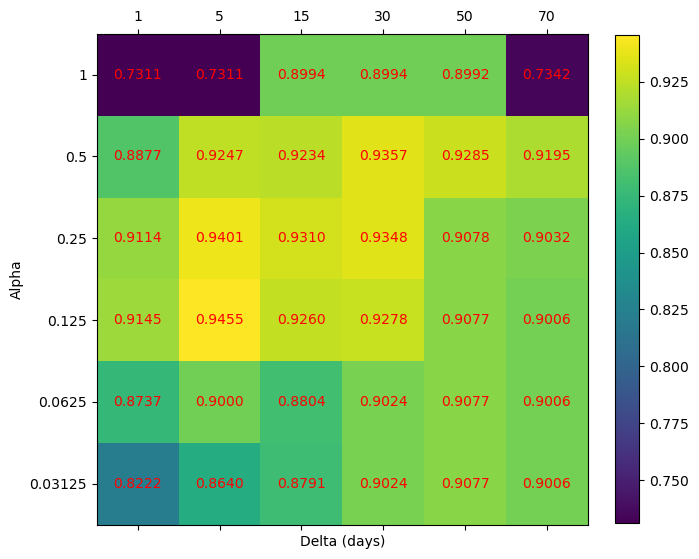

In [12]:
import numpy as np
import matplotlib.pyplot as plt

figure, axes = plt.subplots(figsize=(7,7))
pos = axes.matshow(results, interpolation='nearest')
figure.colorbar(pos, ax=axes, fraction=0.045)

axes.set_xticks(list(range(len(intervals))))
axes.set_yticks(list(range(len(alphas))))
axes.set_xticklabels(intervals)
axes.set_yticklabels(alphas)
axes.set_xlabel('Delta (days)')
axes.set_ylabel('Alpha')

for (i, j), z in np.ndenumerate(results):
    axes.text(j, i, '{:0.4f}'.format(z), ha='center', va='center', color='red')

plt.show()

In [13]:
# Top K vs Bottom K optimal solutions
K = 1
params_rank = sorted(evaluated, key=lambda x: x[2], reverse=True)
top_k = params_rank[:K]
bottom_k = params_rank[-K:]
highlights = top_k + bottom_k

In [14]:
params_rank

[(0.125, 5, 0.9455375321740807),
 (0.25, 5, 0.940083850892536),
 (0.5, 30, 0.9356988014286617),
 (0.25, 30, 0.9348314381906503),
 (0.25, 15, 0.9309871397615512),
 (0.5, 50, 0.9284585238513584),
 (0.125, 30, 0.9277945244705156),
 (0.125, 15, 0.9259521995421209),
 (0.5, 5, 0.9246556718372487),
 (0.5, 15, 0.9233665099969052),
 (0.5, 70, 0.9194554272514263),
 (0.125, 1, 0.9145323564399946),
 (0.25, 1, 0.9113870689381904),
 (0.25, 50, 0.9077726470218221),
 (0.125, 50, 0.9077397620847345),
 (0.0625, 50, 0.9077397620847345),
 (0.03125, 50, 0.9077397620847345),
 (0.25, 70, 0.9031800776623291),
 (0.0625, 30, 0.9023527638613802),
 (0.03125, 30, 0.9023527638613802),
 (0.125, 70, 0.9005983854722106),
 (0.0625, 70, 0.9005983854722106),
 (0.03125, 70, 0.9005983854722106),
 (0.0625, 5, 0.9000024144800666),
 (1, 15, 0.8994435999675467),
 (1, 30, 0.8994435999675467),
 (1, 50, 0.899162898012029),
 (0.5, 1, 0.8876786082362572),
 (0.0625, 15, 0.8803863529230321),
 (0.03125, 15, 0.8791038967089536),
 (0.06

In [15]:
highlights

[(0.125, 5, 0.9455375321740807), (1, 5, 0.731095782926708)]

## Dismantling comparisons

In [16]:
# Hyperparams to show
hparams_pairs = [(a, d) for a, d, _ in highlights]

In [17]:
# Testing loop
rank_list = []
for alpha, interval in tqdm(hparams_pairs):
    
    # Create a new model instance with params
    model = HModel(content_key=lambda x: x[0],
                   author_key=lambda x: x[1],
                   root_content_key=lambda x: x[2],
                   timestamp_key=lambda x: x[3],
                   flag_key=lambda x: x[4],
                   alpha=alpha,
                   delta=datetime.timedelta(days=interval))

    # Fit the model
    model.time_fit(data)

    # Get the rank and save the running configuration
    rank_list.append((model.get_rank(), alpha, interval))

  0%|          | 0/2 [00:00<?, ?it/s]

### Loading ground truth (misinformation retweet network)

In [18]:
# Retweet networks
dtype = {'source': str,
         'target': str,
         'weight': int}

mis_evaluation_net_df = pd.read_csv('data/evaluation_retweet_network.csv', dtype=dtype)

### Dismantling

In [19]:
# Dismantling loop
dismantling_tests = []
for r, a, i in tqdm(rank_list):
    seq = network_dismantle(mis_evaluation_net_df, pd.DataFrame.from_dict(r, orient='index'))
    dismantling_tests.append((seq, a, i))

  0%|          | 0/2 [00:00<?, ?it/s]

### Plot results

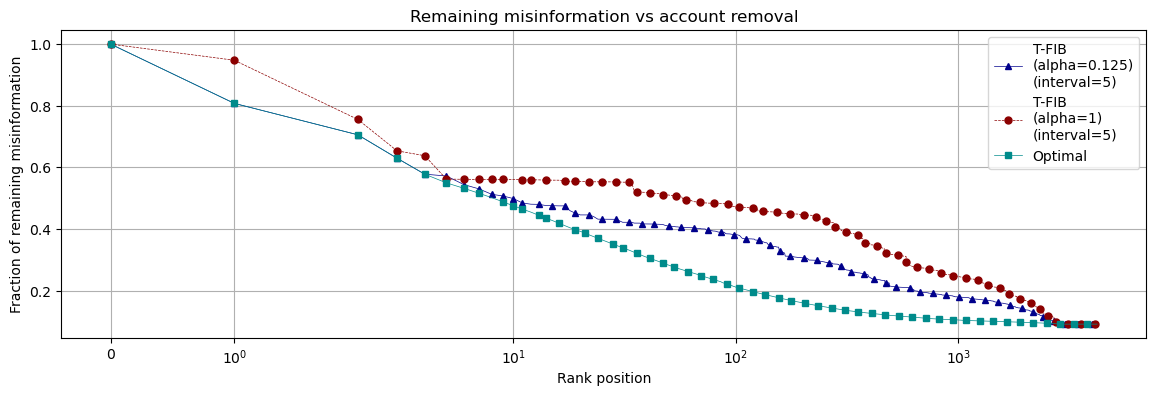

In [32]:
# Build a DataFrame with results
to_df_dict = dict()
for seq, a, i in dismantling_tests:
    to_df_dict[f'T-FIB\n(alpha={a})\n(interval={i})'] = [y for _, y in seq]
# Add the optimal rank dismantle sequence    
to_df_dict['Optimal'] = [y for _, y in network_dismantle(mis_evaluation_net_df, optimal_rank_df)]
# Convert to dataframe
dismantle_df = pd.DataFrame(to_df_dict)

# Set up the plot
colors = ['darkblue', 'darkred', 'darkcyan']#'darkgreen', 'darkmagenta', 'darkcyan']
styles = ['^-', 'o--', 's-' , '*-', '+-']
ax = dismantle_df.plot.line(logx='sym',
                            figsize=(14, 4),
                            grid=True,
                            color=colors,
                            style=styles,
                            linewidth=0.5,
                            markevery=0.012,
                            ms=5,
                            title='Remaining misinformation vs account removal')

ax.set_ylabel("Fraction of remaining misinformation")

ax.set_xlabel("Rank position");

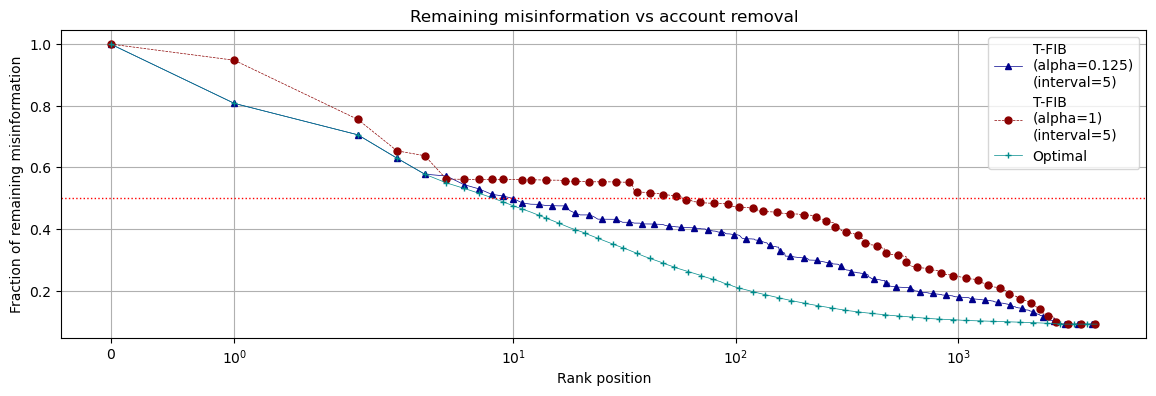

In [31]:
# Set up the plot
colors = ['darkblue', 'darkred', 'darkcyan']
styles = ['^-', 'o--',  '+-']
ax = dismantle_df.iloc[:, [0,1,-1]].plot.line(logx='sym',
                                            figsize=(14, 4),
                                            grid=True,
                                            color=colors,
                                            style=styles,
                                            linewidth=0.5,
                                            markevery=0.012,
                                            ms=5,
                                            title='Remaining misinformation vs account removal')

ax.axhline(y=0.50, xmin=0, color='red', linestyle='dotted', linewidth=1, label='removed misinf')

ax.set_ylabel("Fraction of remaining misinformation")

ax.set_xlabel("Rank position");

In [22]:
# TODO: show horizontal line to show misinformation measure at rank